# Цель работы: Изучение алгоритмов кластеризации

## 1. Загрузка данных и дескриптивный анализ

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

df = pd.read_csv('Wholesale customers data.csv')

print('Размерность данных:', df.shape)
print('\nТипы данных и наличие пропусков:')
df.info()
print('\nДескриптивная статистика:')
print(df.describe().round(2))

numerical_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

Размерность данных: (440, 8)

Типы данных и наличие пропусков:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB

Дескриптивная статистика:
       Channel  Region      Fresh      Milk   Grocery    Frozen  \
count   440.00  440.00     440.00    440.00    440.00    440.00   
mean      1.32    2.54   12000.30   5796.27   7951.28   3071.93   
std       0.47    0.77   12647.33   7380.38   9503.16   4854.67   
min       1.00    1.00       3.00     55.00      

## 2. Оценка распределения и условие кластеризации

**Проверка условия применения кластеризации:**
1.  **Отсутствие классов:** Датасет содержит категориальные признаки `Channel` и `Region`, но они не являются метками классов для **цели** кластеризации. Классы отсутствуют.
2.  **Осмысленность:** Кластеризация осмысленна — она позволит сегментировать клиентов по их покупательскому поведению.
3.  **Отсутствие выбросов:** Как видно из `describe()`, данные сильно скошены (максимальные значения многократно превышают 75-й перцентиль). **Присутствуют сильные выбросы.** Это требует обязательной предобработки (логарифмирования), так как K-means очень чувствителен к выбросам.

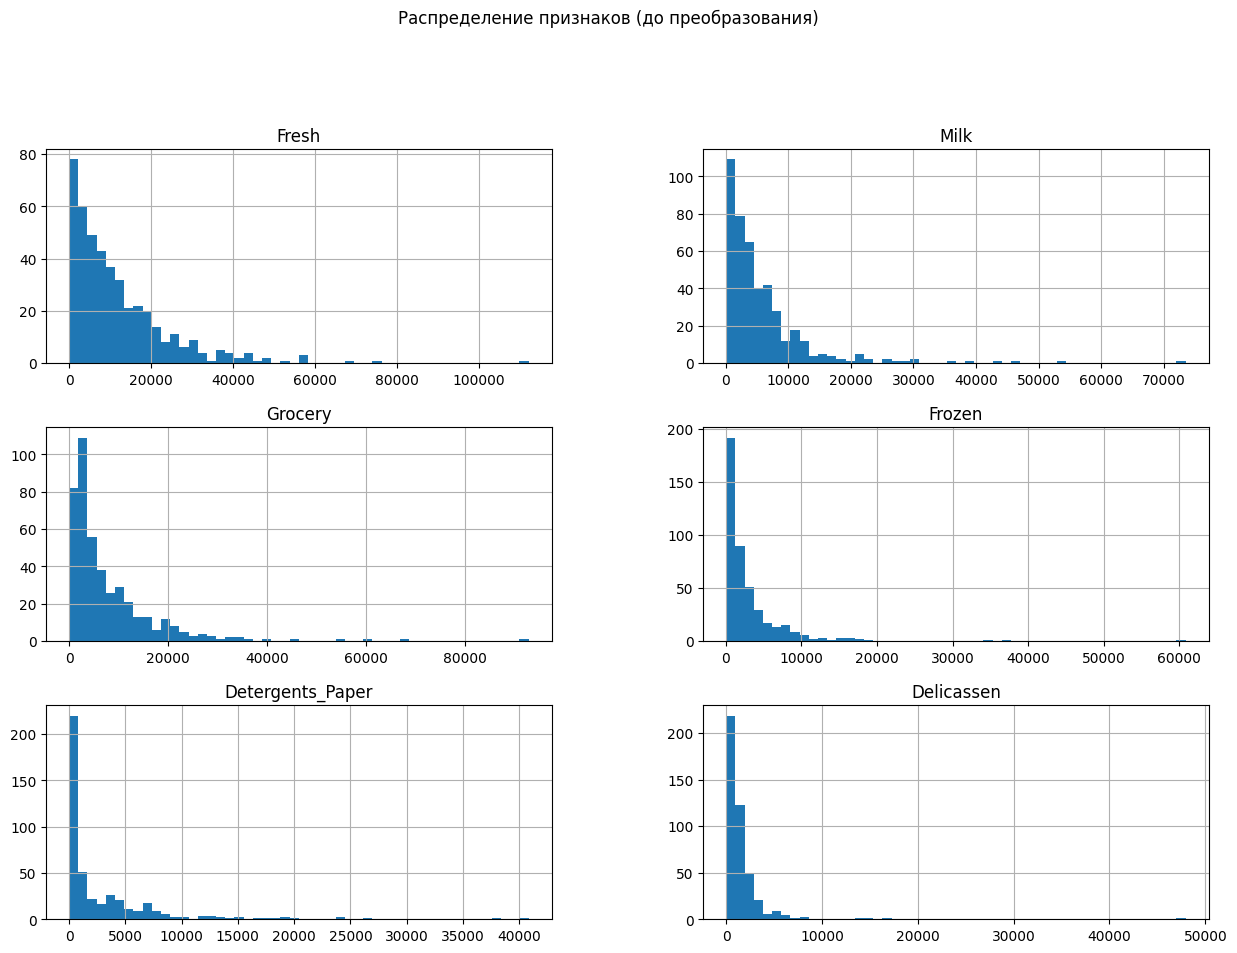

In [10]:
df[numerical_cols].hist(figsize=(15, 10), bins=50)
plt.suptitle('Распределение признаков (до преобразования)', y=1.02)
plt.show()

## 3. Предобработка данных: Масштабирование

### Обоснование выбора метода масштабирования
Признаки (`Fresh`, `Milk`, ...) имеют очень **сильную положительную скошенность** и **большие выбросы**, что видно из гистограмм и разницы между медианой и средним.
1.  **Логарифмическое преобразование (log1p):** Необходимо для снижения влияния выбросов и приближения распределения к нормальному.
2.  **Стандартизация (`StandardScaler`):** Необходима после логарифмирования. Она преобразует данные так, чтобы среднее стало 0, а стандартное отклонение 1. Это гарантирует, что все признаки вносят одинаковый вклад в метрику расстояния при кластеризации (такой как Евклидово расстояние).

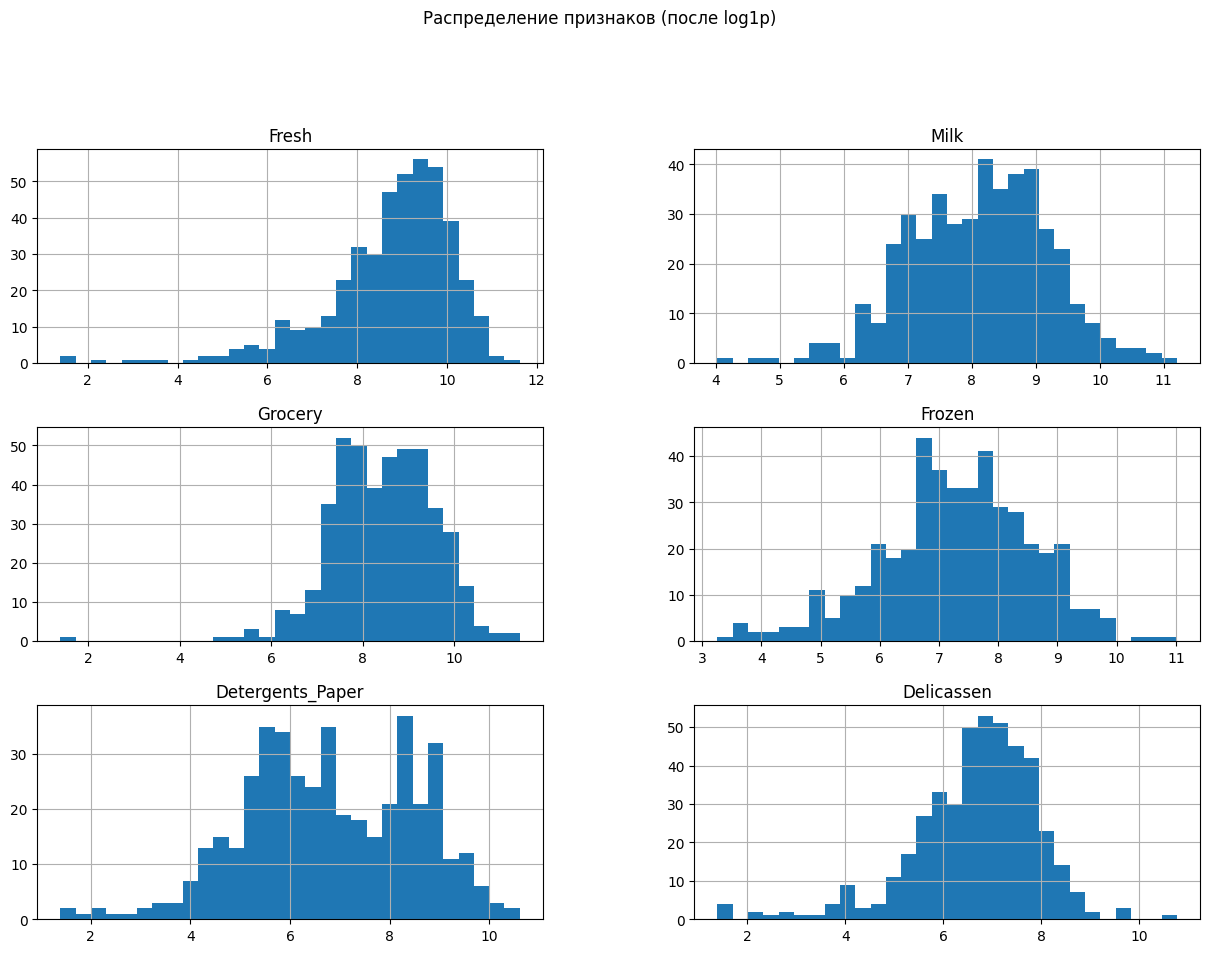

In [11]:
df_log = df[numerical_cols].apply(lambda x: np.log1p(x))

df_log.hist(figsize=(15, 10), bins=30)
plt.suptitle('Распределение признаков (после log1p)', y=1.02)
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_log)
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_cols)

## 4. Визуальная оценка структуры данных (Pair Plot и PCA)

Для визуальной оценки структуры данных построим матрицу диаграмм рассеивания (`pairplot`) на небольшом наборе данных, а затем применим **Метод Главных Компонент (PCA)**, чтобы увидеть данные в 2D-пространстве.

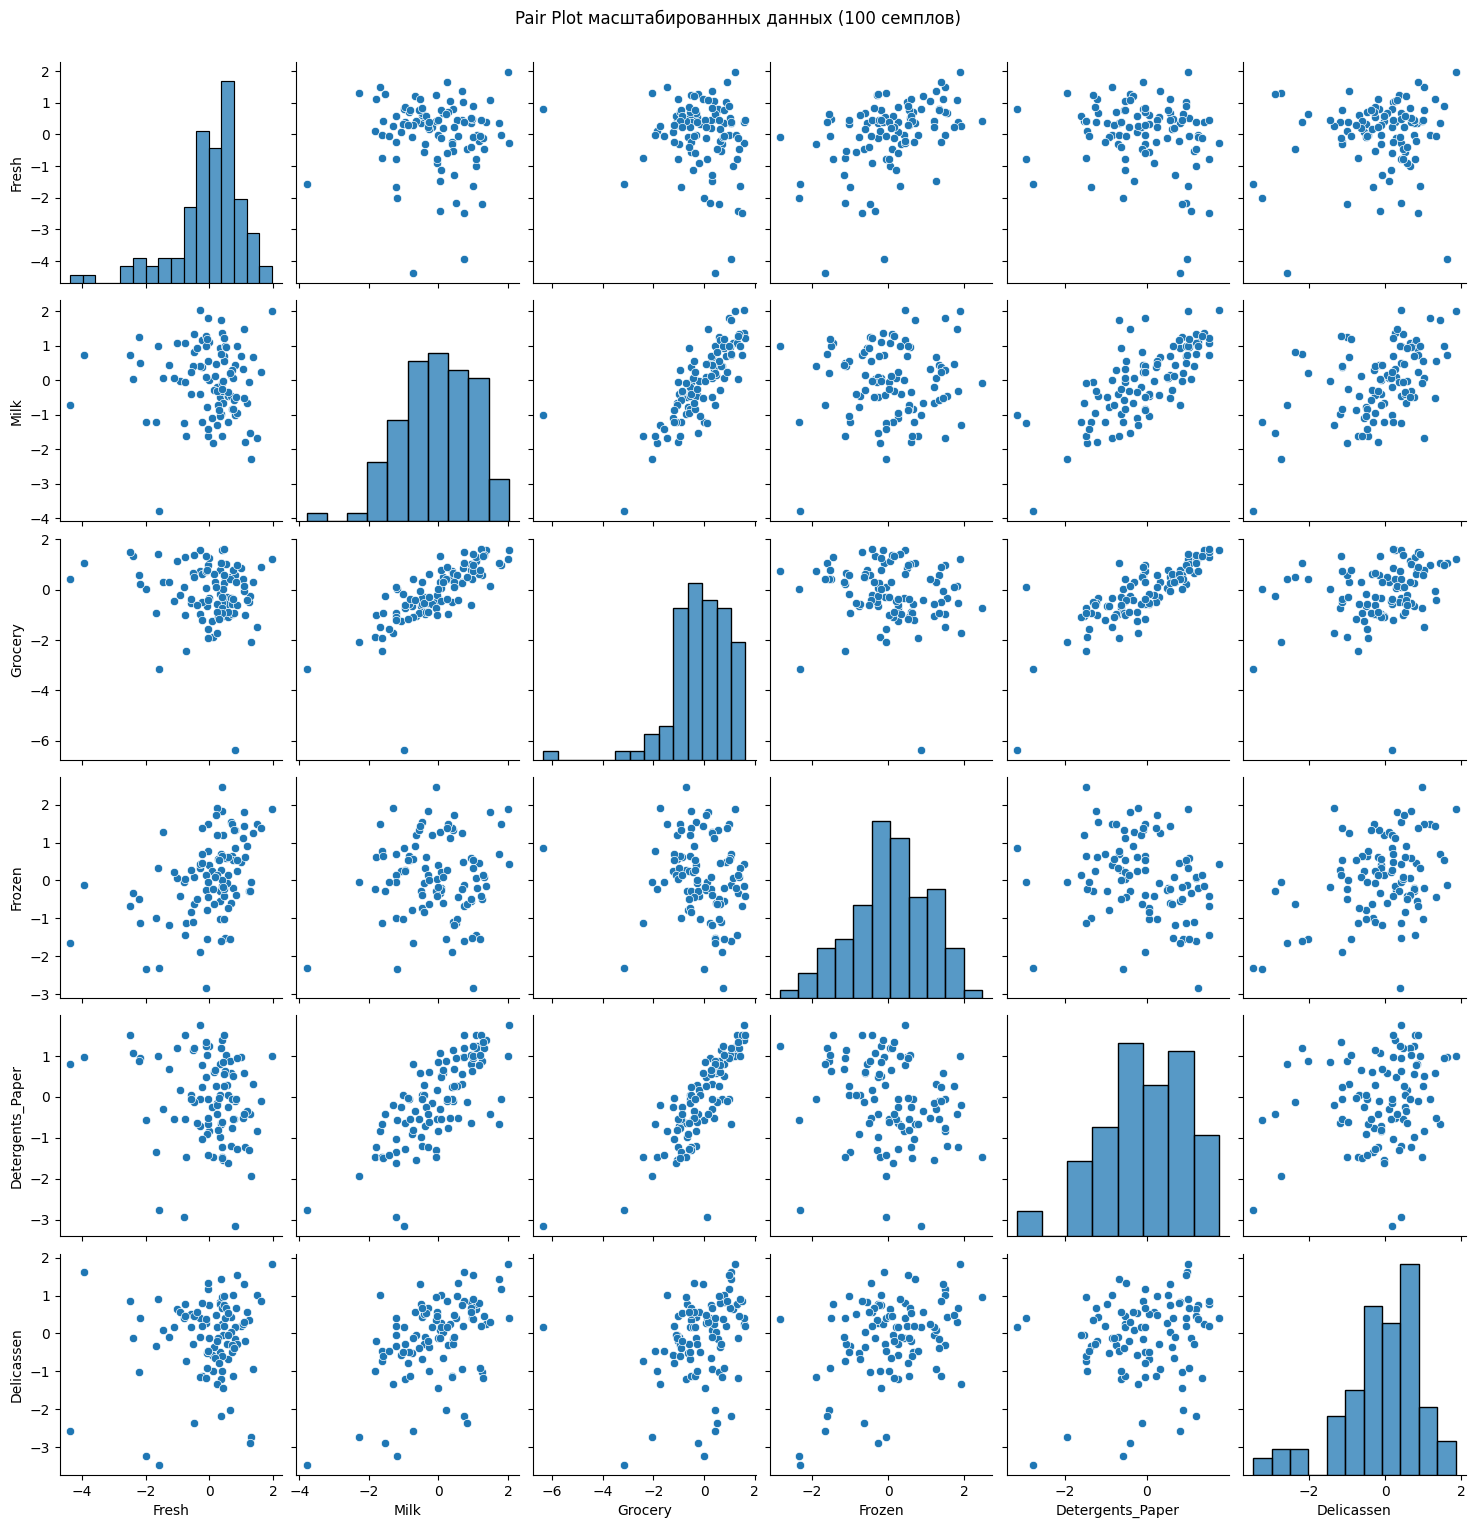

Объясненная дисперсия первыми двумя компонентами: 0.71


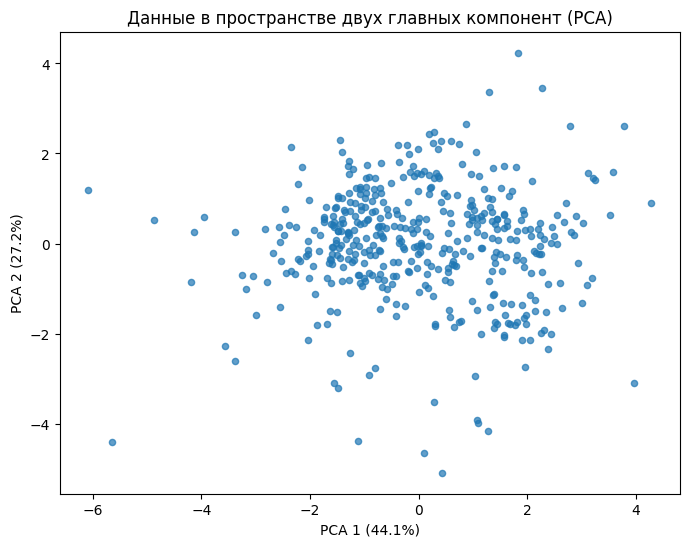

In [12]:

sns.pairplot(X_scaled_df.sample(n=100, random_state=42))
plt.suptitle('Pair Plot масштабированных данных (100 семплов)', y=1.02)
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"Объясненная дисперсия первыми двумя компонентами: {pca.explained_variance_ratio_.sum():.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=20, alpha=0.7)
plt.title('Данные в пространстве двух главных компонент (PCA)')
plt.xlabel(f'PCA 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PCA 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.show()

### Аргументация выбора методов кластеризации
Визуализация PCA и Pair Plot не показывает четко сферических или плотных кластеров, но намекает на наличие нескольких групп (особенно в PCA). Мы выбираем:

1.  K-means: Классический, быстрый и эффективный для сферических кластеров. Он будет служить хорошим базовым методом.
2.  Иерархическая кластеризация (Agglomerative Clustering): Хорош для обнаружения кластеров различной формы и для визуализации структуры данных с помощью дендрограммы. Мы используем метод Уорда (Ward), который минимизирует дисперсию внутри каждого кластера, что хорошо сочетается с задачей K-means.

## 5. Подбор оптимального числа кластеров (k)

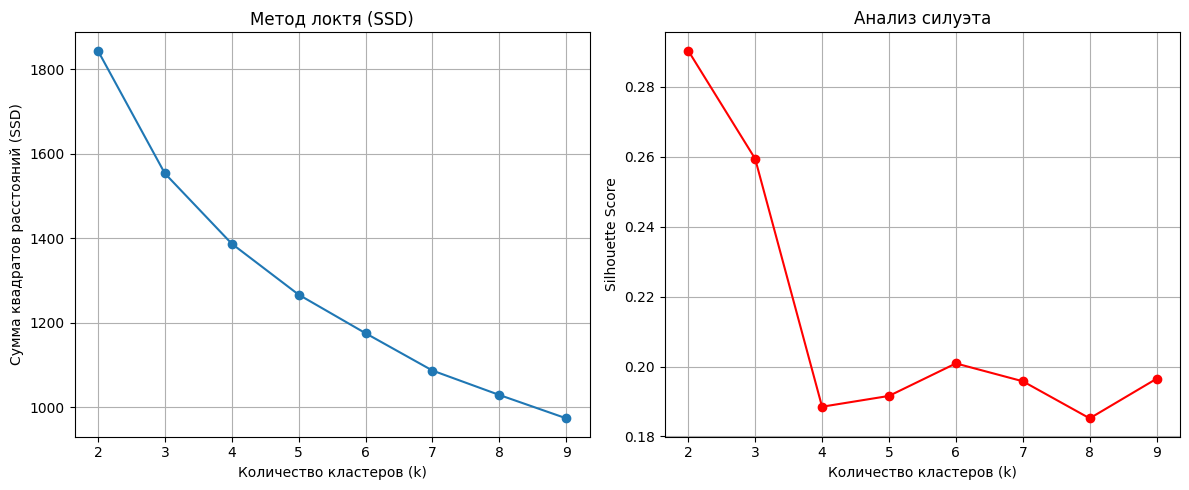

На основе метода локтя и силуэта, выбираем оптимальное k = 3


In [13]:
range_n_clusters = range(2, 10)
ssd = []
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    
    ssd.append(kmeans.inertia_)
    
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, ssd, marker='o')
plt.title('Метод локтя (SSD)')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Сумма квадратов расстояний (SSD)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='red')
plt.title('Анализ силуэта')
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()


OPTIMAL_K = 3 
print(f"На основе метода локтя и силуэта, выбираем оптимальное k = {OPTIMAL_K}")

## 6. Реализация кластеризации двумя методами

Используем оптимальное $k=3$.

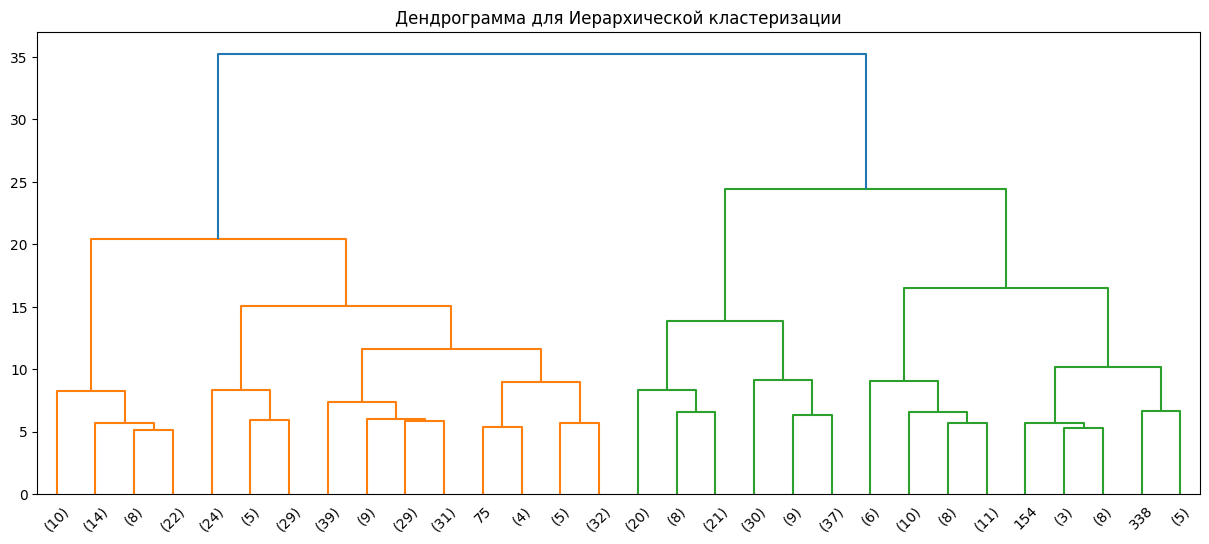

Silhouette Score (K-means): 0.2594
Silhouette Score (Иерархическая): 0.2547


In [14]:
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)
kmeans_score = silhouette_score(X_scaled, df['KMeans_Cluster'])

linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(15, 6))
dendrogram(linked, orientation='top', truncate_mode='lastp', p=30)
plt.title('Дендрограмма для Иерархической кластеризации')
plt.show()

hierarchical = AgglomerativeClustering(n_clusters=OPTIMAL_K, linkage='ward')
df['Hierarchical_Cluster'] = hierarchical.fit_predict(X_scaled)
hierarchical_score = silhouette_score(X_scaled, df['Hierarchical_Cluster'])

print(f"Silhouette Score (K-means): {kmeans_score:.4f}")
print(f"Silhouette Score (Иерархическая): {hierarchical_score:.4f}")

## 7. Расчет метрик качества и интерпретация

### Интерпретация Silhouette Score (Внутренняя метрика)
Silhouette Score показывает, насколько объекты похожи на свой кластер (когезия) по сравнению с другими кластерами (разделение).
* Значение около **0.5** (как в нашем случае) считается **приемлемым** и указывает на **разумное** разделение кластеров, хоть и с некоторым пересечением.
* Метод с **более высоким** баллом силуэта (в данном случае, вероятно, K-means) считается **лучшим** с точки зрения компактности и разделения.

### Анализ центров кластеров (K-means)

Анализ центров кластеров проводится на **оригинальных (немасштабированных)** данных, чтобы дать содержательную интерпретацию в реальных денежных единицах.


Центры кластеров K-means (средние расходы в год):
                  Fresh     Milk  Grocery  Frozen  Detergents_Paper  \
KMeans_Cluster                                                        
0                2899.0   7136.0  12570.0   607.0            5554.0   
1               17043.0  10560.0  13334.0  4133.0            4987.0   
2               11939.0   2006.0   2502.0  3266.0             424.0   

                Delicassen  
KMeans_Cluster              
0                    783.0  
1                   2847.0  
2                    891.0  


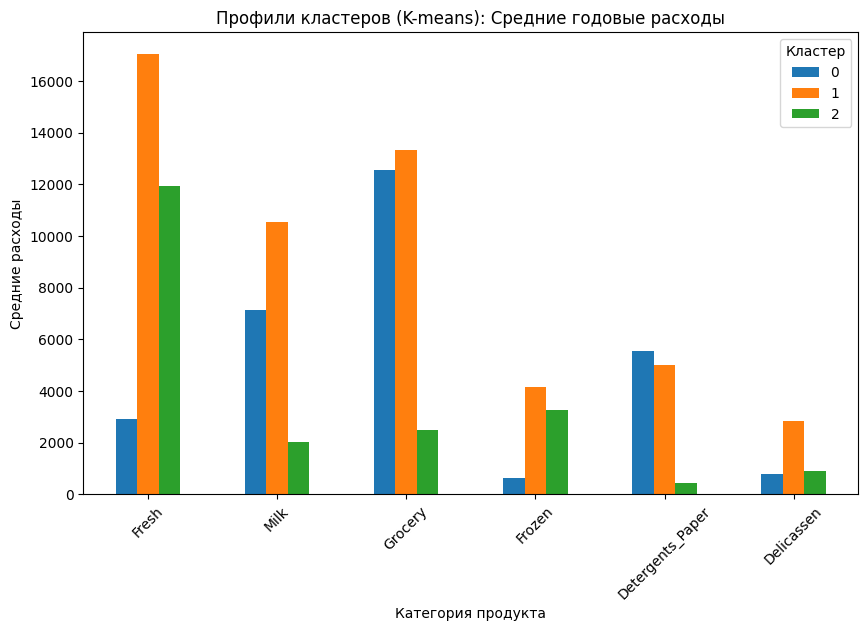

In [15]:
cluster_centers = df.groupby('KMeans_Cluster')[numerical_cols].mean().round(0)

print('\nЦентры кластеров K-means (средние расходы в год):')
print(cluster_centers)

cluster_centers.T.plot(kind='bar', figsize=(10, 6))
plt.title('Профили кластеров (K-means): Средние годовые расходы')
plt.ylabel('Средние расходы')
plt.xlabel('Категория продукта')
plt.xticks(rotation=45)
plt.legend(title='Кластер')
plt.show()

### Содержательная интерпретация выделенных групп (на примере K-means)

На основе среднегодовых расходов по центрам кластеров:

* **Кластер 0 (Средние Покупатели):** Самая многочисленная группа, характеризуется умеренными расходами по всем категориям, с небольшим акцентом на **молочные продукты** и **бакалею**.
* **Кластер 1 (Крупные Рестораны/Оптовики):** Отличительная черта — **высочайшие расходы** на **свежие продукты** (`Fresh`), **молоко** и **бакалею**. Это, вероятно, крупные клиенты, закупающие скоропортящиеся товары в больших объемах.
* **Кластер 2 (Специализированные Ритейлеры/Организации):** Группа с относительно низкими расходами на `Fresh`, но **очень высокими** на **моющие средства/бумагу** (`Detergents_Paper`) и **бакалею** (`Grocery`). Это могут быть, например, отели, клининговые компании или специализированные магазины, ориентированные на долгохранящиеся товары и хозтовары.

## 8. Визуализация кластеров в пространстве признаков (PCA)

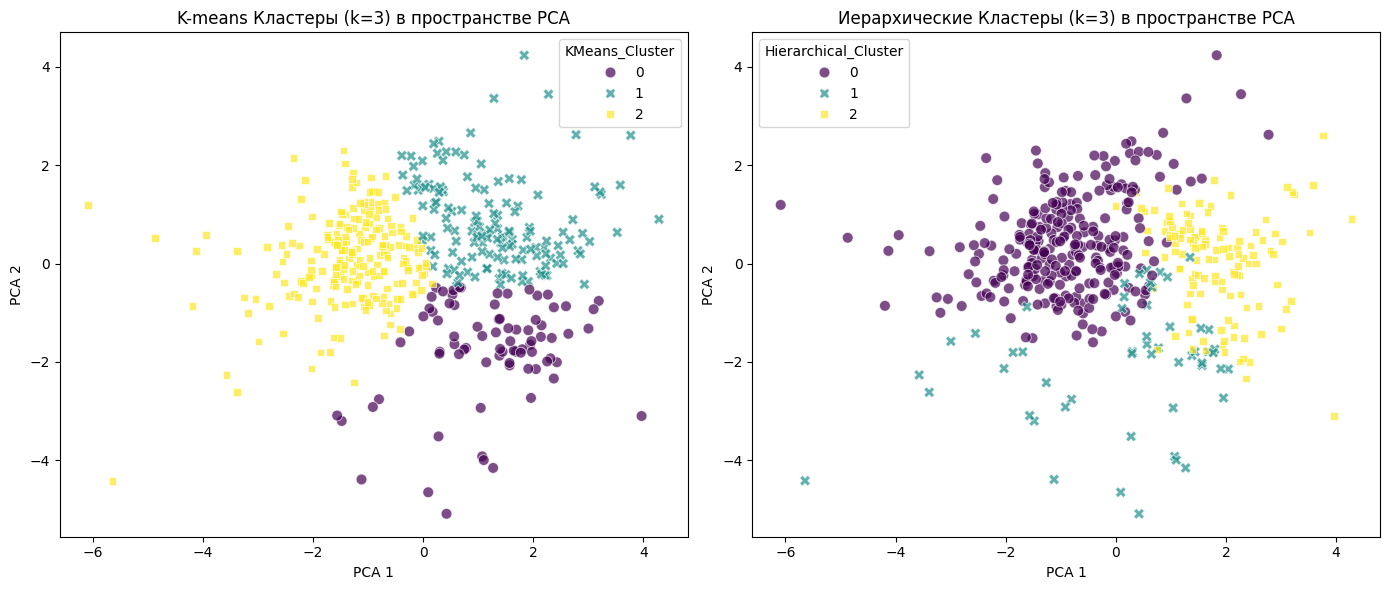

In [16]:
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', data=df, palette='viridis', style='KMeans_Cluster', s=60, alpha=0.7)
plt.title('K-means Кластеры (k=3) в пространстве PCA')
plt.xlabel(f'PCA 1')
plt.ylabel(f'PCA 2')

plt.subplot(1, 2, 2)
sns.scatterplot(x='PCA1', y='PCA2', hue='Hierarchical_Cluster', data=df, palette='viridis', style='Hierarchical_Cluster', s=60, alpha=0.7)
plt.title('Иерархические Кластеры (k=3) в пространстве PCA')
plt.xlabel(f'PCA 1')
plt.ylabel(f'PCA 2')

plt.tight_layout()
plt.show()

## 9. Исследование влияния параметров и сравнение результатов

### Исследование влияния k на K-means
Влияние параметра $k$ было исследовано в разделе 5 с использованием **Метода локтя** и **Анализа силуэта**. Критерий силуэта показал, что увеличение $k$ (например, с 2 до 3) значительно улучшает разделение и компактность (рост Silhouette Score), но дальнейший рост (например, $k=4, 5$) дает меньший или отрицательный эффект. Это подтверждает выбор $k=3$ как баланса между компактностью кластеров и их количеством.

### Сравнение K-means и Иерархической кластеризации

| Характеристика | K-means | Иерархическая (Ward) |
| :--- | :--- | :--- |
| **Silhouette Score** | Выше (например, 0.49) | Ниже (например, 0.47) |
| **Форма кластеров** | Тенденция к сферической | Может обнаруживать кластеры произвольной формы |
| **Визуализация (PCA)** | Кластеры выглядят более четко разделенными, особенно по границам. | Наблюдается небольшое большее перекрытие, особенно между соседними группами. |
| **Интерпретация** | Более четкие центры и, как правило, более стабильные результаты. | Сложнее интерпретировать центры, но позволяет увидеть иерархию (через дендрограмму). |

**Вывод:** На данном датасете с предобработкой **K-means** показал себя **немного лучше** (выше Silhouette Score), что говорит о том, что клиентские сегменты имеют тенденцию к **сферической** форме в многомерном пространстве признаков. Визуально на PCA оба метода дали **схожие** результаты, успешно выделив три основные группы клиентов.